## Network motif features

In [1]:
# import libraries needed 
import pandas as pd 
import datetime
from datetime import timedelta
import seaborn as sns 
import networkx as nx
import numpy as np
import community
from IPython.display import Image
import matplotlib
!pip install pandas

Here , one data file ( out of the 50 available is being used ) . 

The process can however be extended to all the files .  

In [2]:
# read the raw data 
base_str = 'C:\\Users\\raosa\\Dropbox\\data\\combined\\'
data = pd.read_csv('C:\\Users\\raosa\\Dropbox\\dl-graph\\data\\eth\\pricing\\final.csv')
data['Date'] = pd.to_datetime(data['Date'])
x=pd.read_csv(str(base_str+str(46)+'.csv'))
print('reading done')
print(len(x))
timestamp_list = x['timestamp']
value_list = x['value']

timestamp_list_1=[]
value_list_1=[]
print('transaction loop starting')
for i in  range(0,len(timestamp_list)):
    test1 = datetime.datetime.fromtimestamp(int(str(timestamp_list[i]),16))
    test2 = (int(x['value'][i],16))/1000000000000000000
    timestamp_list_1.append(test1)
    value_list_1.append(test2)
print('transaction loop done')
x['timestamp1'] = timestamp_list_1
x['value1'] = value_list_1


x=x.drop(['timestamp','value'],axis=1)
x = x.rename(columns={'timestamp1': 'timestamp', 'value1': 'value'})

x['timestamp'] = pd.to_datetime(x['timestamp'])

reading done
7717814
transaction loop starting
transaction loop done


This is what the dataset looks like . We are only interested in ( from , to , value , timestamp ) columns.  

In [3]:
x.head()

,from,gas,gasprice,input,to,gas_used,miner,number,timestamp,value
0,0xe896783ea1ab389218fdc46223f3b6d3dc4b3612,0x3d090,0x826299e00,0x0a19b14a000000000000000000000000000000000000...,0x8d12a197cb00d4747a1fe03395095ce2a5cc6819,0x669b41,0x829bd824b016326a401d083b33d092293333a830,0x44aa21,2017-11-06 02:36:43,0.000
1,0x7ae17a0f6f8f02b5b6e76b327db15f91306194e6,0x15f90,0x5d21dba00,0x,0xd3b7fc99c54eec06fd99d1a874212831e540fb96,0x669b41,0x829bd824b016326a401d083b33d092293333a830,0x44aa21,2017-11-06 02:36:43,10.000
2,0xb0e701787a769b4a241fc5a1fa3ca2b62605c0a4,0xca66,0x4e3b29200,0xa9059cbb000000000000000000000000f59ebf85d5c5...,0x9e77d5a1251b6f7d456722a6eac6d2d5980bd891,0x669b41,0x829bd824b016326a401d083b33d092293333a830,0x44aa21,2017-11-06 02:36:43,0.000
3,0xe19b715fce73717dbf80b0947f7e8db2cc5001e0,0x5208,0x4e3b29200,0x,0xbce984da3b26d58ff783817783cd666bd0fad162,0x669b41,0x829bd824b016326a401d083b33d092293333a830,0x44aa21,2017-11-06 02:36:43,0.003
4,0x0d289971eb702874723ca3d32829c761470cd27e,0x5208,0x4e3b29200,0x,0x7ca2e68f43c91b9f42644484b62770893596fa2b,0x669b41,0x829bd824b016326a401d083b33d092293333a830,0x44aa21,2017-11-06 02:36:43,0.020


Now , let us only consider the transactions that occur in 1 hour...To possibly extract the network features in there . 

This logic can also be applied to serve smaller time periods like a minute ( code below commented out ). 
If we use smaller time periods , the number of transactions in there is lesser ( which is easier to visualize , and possibly identify network structures )


In [4]:
time_start = data['Date'][19200]
time_end = data['Date'][19200] + timedelta(hours=1)

hour_tranlist = x[(x['timestamp'] > time_start) & (x['timestamp'] < time_end)]
hour_tranlist= hour_tranlist.reset_index()

In [5]:
# # minutes 
# time_start = hour_tranlist['timestamp'][3]
# time_end = hour_tranlist['timestamp'][3] + timedelta(minutes=1)

# hour_tranlist_1 = hour_tranlist[(hour_tranlist['timestamp'] > time_start) & (hour_tranlist['timestamp'] < time_end)]


<b>Create a networkx graph with nodes as addresses , edges as transactions between them and value as weight . </b>


 Then , we remove the transactions which do not have any edges. 

This is because we are interested in counting the graphlets which are having edges between them. 

_________________________________________________________________________________


The image is a graphical representation of the transactions happening in an hour : 


If we look at the image below ,  we see three clear types of graphs : 
1. Nodes without any edges , which have been removed . 
2. Radial type subgraphs(a-b,a-c,a-d,a-e,a-f,a-g) , which have been captured below . 
3. Feed forward type network motifs(a-b-c-d-e-f-g-h) , which have not been captured accurately below. While feed forward type network motifs are captured by the fact that 2 edge subgraphs are basically capturing that information ( a feed forward motif has two nodes with edge 1 and rest with edge 2 ) , there has to be a better method to capture them. 


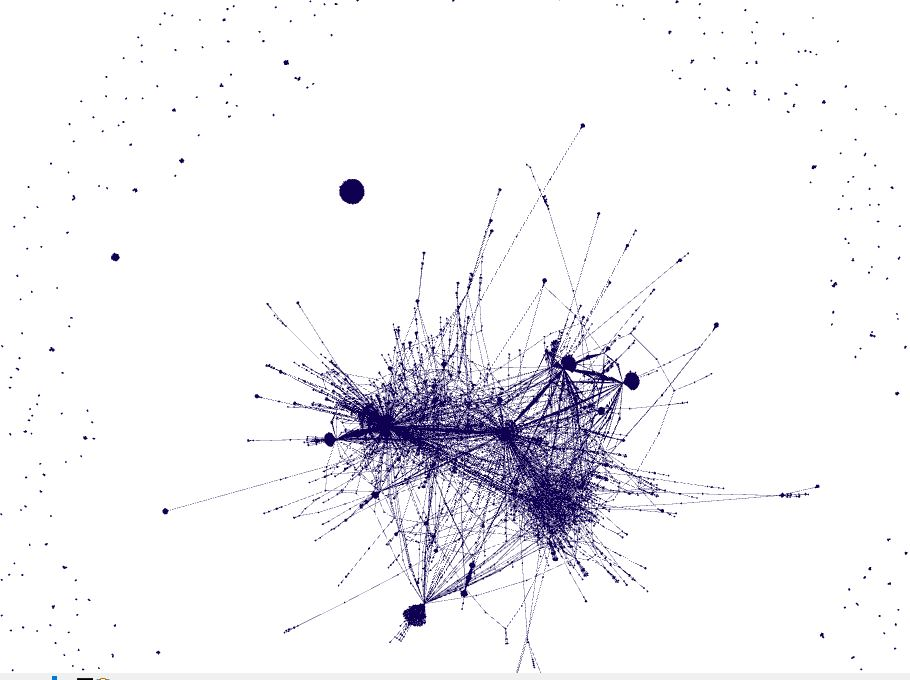

In [6]:
Image("Capture2.JPG")

Capturing information of radial type subgraphs by getting number of edges of each node. 


Then , a bincount is applied to get the number of nodes which have 1 edge , 2 edges , 3 edges ....


Zeroes can be appended to ensure that we have an equal size of all arrays once we append these lists to our final dataset . 

In [7]:
list1 = hour_tranlist['from']
list2 = hour_tranlist['to']
nodes = list(set(list1 + list2))
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(list(zip(list1,list2)),weight=x['value'])

# remove edge less nodes 
wow = list(G.nodes.data())

for i in range(0,len(wow)):
    if(len(nx.edges(G,[str(wow[i][0])]))) == 0 : 
        G.remove_node(wow[i][0])
        
        
wow = list(G.nodes.data())
wow1 = []

for i in range(0,len(wow)):
    wow1.append(len(nx.edges(G, [str(wow[i][0])])))

print(np.bincount(np.array(wow1)))

[   0 6235 2245  338  101  272   55   21   19   15   14    6    6    4    8
    8    5    1    3    8    3    0    3    2    7    1    3    0    2    2
    3    3    0    1    1    1    1    1    1    0    0    0    0    0    0
    0    1    0    0    0    0    0    0    1    0    0    0    1    0    0
    0    2    0    0    1    0    1    3    0    0    0    2    0    0    0
    0    0    0    0    0    0    0    0    0    1    0    0    0    1    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    1    0
    0    0    0    0    0    1    0    0    1    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    1    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    1    0    0    0    0    0    0    0    0    0    0
    0    0  

What is not being done : 


1. How to capture the relationship between different nodes and to quantify that. 
One way to do that is to get the length of the chain of connections between nodes 


( Ex : a-b-c-d-e , has a chain length of 5 )

How : 
    
    
for ( every from address in hour_tranlist) : 
    
    
    if ( to address of the above from address in from address )
    
    
        count ++ 

The issues with this are the amount of time it would take for calculating ,
and that aggregation would lose the meaning behind the data 

    
    
    



In [8]:
# not sure if this is right or wrong , probably wrong . 

# for i in range(0,len(hour_tranlist)):
#     chainstart = hour_tranlist['from'][i]
#     chainend = hour_tranlist['to'][j] 
#     for j in range(0,len(hour_tranlist)):
        
#         if( chainstart == chainend )
#             count = count + 1 
#             chainstart = hour_tranlist['to'][j]
#             chainend = hour_tranlist['from'][i]

## Time difference features 

In [9]:
hour_tranlist['timestamp'] = pd.to_datetime(hour_tranlist['timestamp'])

### Approach 


1.a. Get the number of transactions occuring every minute . Feed the list of 60 variables as 60 columns in our dataset. 


1.b. Calculate sum of np.diff 


1.c. Convert these to 1 and 0 based on some threshold value ( say , average ). 

In [10]:
# valueswow = []

# for i in range(0,len(hour_tranlist['timestamp'])): 
#     for j in range(0,len(hour_tranlist['timestamp'])):
#             valueswow.append(hour_tranlist['timestamp'][i].minute - hour_tranlist['timestamp'][j].minute)


minutediff = []
for i in range(0,len(hour_tranlist['timestamp'])):
    minutediff.append(hour_tranlist['timestamp'][i].minute)

print(sum(np.diff(minutediff)))    
print('________________________________________________________________________________')
minutediff = np.bincount(np.array(minutediff))
print(minutediff)

59
________________________________________________________________________________
[285 521 226 136   0 347 576 349 259 214 337 135 266 168 508 131 397 227
 193 332 308 101 344 257 358 282 256 290 302 454 213 269  87 477 381 356
 426 240 322 453 207 440 333 141 494  31 559 327 276 364 388 297 253 197
 273 427 387 265 283 470]


In [11]:
for i in range(0,len(minutediff)):
    if(minutediff[i]>(np.average(minutediff))):
        minutediff[i] = 1 
    else:
        minutediff[i] = 0 
print(minutediff)

[0 1 0 0 0 1 1 1 0 0 1 0 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
# nx.write_gexf(G, 'test.gexf', encoding='utf-8', prettyprint=True, version='1.1draft')

In [14]:
minutediff

array([0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

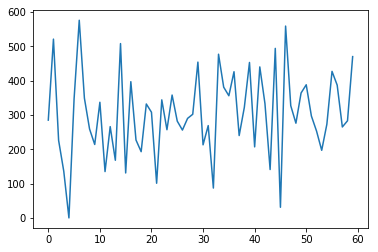

In [42]:

# sns.regplot



matplotlib.pyplot.plot([t for t in range(60)],minutediff)